In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def preprocess_data(file_path, model_type):
    """
    Preprocess the data based on the model type.
    
    Args:
        file_path (str): Path to the dataset file.
        model_type (str): Model type ("RF", "SVM", "ANN").
    
    Returns:
        X, y, X_train, X_test, y_train, y_test: Processed features and labels, split into training and testing sets.
    """
    # Read data
    df = pd.read_csv(file_path)
    
    # Handle missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_imputed = imputer.fit_transform(df.drop(['quality'], axis=1))
    y = df['quality']
    
    # Feature normalization
    scaler = StandardScaler()
    X = scaler.fit_transform(X_imputed)
    
    if model_type == "ANN":
        # One-hot encode the labels for ANN
        y = to_categorical(y)
        num_classes = y.shape[1]  # This should correctly reflect the number of classes
    else:
        num_classes = len(np.unique(y))  # For non-ANN models if needed elsewhere
        print(np.unique(y))
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    return X, y, X_train, X_test, y_train, y_test, num_classes  # Return num_classes to use in model creation

In [2]:
import numpy as np
import joblib
import json
import os
import psutil
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback

class MemoryCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        process = psutil.Process(os.getpid())
        # print(f"Memory usage at epoch {epoch}: {process.memory_info().rss / 1024 ** 2:.2f} MB")

def create_model(neurons, layers, input_shape, num_classes):
    """
    Function to create and compile a neural network model.
    
    Args:
        neurons (int): Number of neurons in each hidden layer.
        layers (int): Number of hidden layers.
        input_shape (int): The number of features in the training data.
        num_classes (int): The number of classes in the target labels.
    
    Returns:
        model (Keras model): Compiled neural network model.
    """
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_shape, activation='relu'))
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Ensure this matches the number of classes
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    
def train_and_evaluate_model(X_train, y_train, X_test, y_test, neurons, layers, epochs, batch_size, num_classes):
    model = create_model(neurons=neurons, layers=layers, input_shape=X_train.shape[1], num_classes= num_classes)
    memory_callback = MemoryCallback()
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[memory_callback])
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]  # Return accuracy

from tensorflow.keras.models import load_model

def hyperparameter_tuning(X_train, y_train, model_type, result_file, num_classes):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = {}
    test = 0

    if model_type in ["RF", "SVM"]:
        if model_type == "RF":
            params = {
                'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
                'max_depth': [None, 10, 20, 30, 40, 50],
                'min_samples_split': [2, 5, 10]
            }
            model = RandomForestClassifier(random_state=42)
        elif model_type == "SVM":
            params = {
                'C': [0.1, 1, 10, 100],
                'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                'gamma': ['scale', 'auto', 0.1, 1, 10]
            }
            model = SVC(random_state=42)
            
        grid_search = GridSearchCV(model, params, cv=kf, scoring='accuracy', n_jobs=-1, verbose=1)
        
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        results = grid_search.cv_results_

        # Save results and model using joblib
        joblib.dump(best_model, f'saved_models/{model_type}_best_model_{result_file}.pkl')
    elif model_type == "ANN":  # For ANN
        best_score = 0
        best_params = None
        results['mean_test_score'] = []
        results['params'] = []

        param_grid = {
            'neurons': [16, 32, 64],
            'layers': [1, 2, 3],
            'epochs': [50, 100, 150],
            'batch_size': [10, 20, 30]
        }

        # param_grid = {'neurons': [16], 
        #               'layers': [1, 2], 
        #               'epochs': [50], 
        #               'batch_size': [10]}
        
        for neurons in param_grid['neurons']:
            for layers in param_grid['layers']:
                for epochs in param_grid['epochs']:
                    for batch_size in param_grid['batch_size']:
                        scores = []
                        for train_index, test_index in kf.split(X_train):
                            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
                            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
                            score = train_and_evaluate_model(X_train_fold, y_train_fold, X_test_fold, y_test_fold, neurons, layers, epochs, batch_size, num_classes)
                            scores.append(score)
                        mean_score = np.mean(scores)
                        results['mean_test_score'].append(mean_score)
                        results['params'].append({
                            'neurons': neurons, 'layers': layers, 'epochs': epochs, 'batch_size': batch_size
                        })
                        if mean_score > best_score:
                            best_score = mean_score
                            best_params = {
                                'neurons': neurons, 'layers': layers, 'epochs': epochs, 'batch_size': batch_size
                            }
        best_model = create_model(best_params['neurons'], best_params['layers'], X_train.shape[1], num_classes)
        best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        model_save_path = f'{model_type}_best_model_{result_file}.h5'
        best_model.save(model_save_path)
    else:
        print("Wrong typed model")

    # Save results
    result_json_path = f'{model_type}_cv_results_{result_file}.json'
    if results:
        for key in results.keys():
            if isinstance(results[key], np.ndarray):
                results[key] = results[key].tolist()
        with open(result_json_path, 'w') as f:
            json.dump(results, f)
    with open(f'{model_type}_best_params_{result_file}.txt', 'w') as f:
        f.write(json.dumps(best_params))
    return best_model, best_params

In [3]:
import matplotlib.pyplot as plt
import json

def visualize_results(model_type, result_file):
    """
    Load GridSearchCV results from a file and visualize the hyperparameter tuning performance.
    
    Args:
        model_type (str): Model type ("RF", "SVM", "ANN") used for identifying the result file.
    """
    with open(f'{model_type}_cv_results_{result_file}.json', 'r') as f:
        results = json.load(f)
    
    mean_test_scores = results['mean_test_score']
    params = [str(p) for p in results['params']]
    
    plt.figure(figsize=(35, 6))
    plt.plot(params, mean_test_scores, marker='o')
    plt.title(f'Hyperparameter Tuning Results for {model_type}')
    plt.xlabel('Parameters')
    plt.ylabel('Mean Test Score')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

In [16]:
import time
from sklearn.metrics import accuracy_score
import joblib

def test_model(X_train, y_train, X_test, y_test, model_type, result_file):
    """
    Load the best model parameters from a file, construct the model, and test its performance.
    
    Args:
        X_train, y_train, X_test, y_test (np.array): Training and testing data sets.
        model_type (str): Model type ("RF", "SVM", "ANN").
    
    Returns:
        test_accuracy (float): Accuracy on the test set.
    """
    
    model_path = f'{model_type}_best_model_{result_file}'
    if model_type == "ANN":
        model_path += '.h5'  # Keras 
        model = load_model(model_path)
    else:
        model_path += '.pkl'  # joblib 
        model = joblib.load(model_path)

    # Train the model and calculate the training time
    start_time = time.time()
    model.fit(X_train, y_train, verbose=0)
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.4f} seconds.")

    # Evaluate on training data
    y_pred_train = model.predict(X_train, verbose=0)
    y_pred_train = np.argmax(y_pred_train, axis=1)  # Convert prediction results to class labels
    y_train_labels = np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train  # Make sure y_train is in class label form
    training_accuracy = accuracy_score(y_train_labels, y_pred_train)
    print(f"Training Accuracy: {training_accuracy:.4f}")

    # Evaluate on testing data
    y_pred_test = model.predict(X_test, verbose=0)
    y_pred_test = np.argmax(y_pred_test, axis=1)  # Convert prediction results to class labels
    y_test_labels = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test  # Make sure y_test is in class label form
    test_accuracy = accuracy_score(y_test_labels, y_pred_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return test_accuracy


In [5]:
def full_process(file_path, model_type, result_file):
    """
    Run the full process from data preprocessing to model testing and results visualization.
    
    Args:
        file_path (str): Path to the dataset file.
        model_type (str): Model type ("RF", "SVM", "ANN").
    """
    # Data preprocessing
    X, y, X_train, X_test, y_train, y_test, num_classes= preprocess_data(file_path, model_type)
    
    # Hyperparameter tuning
    best_model, best_params= hyperparameter_tuning(X_train, y_train, model_type, result_file, num_classes)
    print(f"Best parameters found: {best_params}")

    # Visualize results
    visualize_results(model_type, result_file)
    
    # Test the model
    test_accuracy = test_model(X_train, y_train, X_test, y_test, model_type, result_file)
    print(f"Final test accuracy: {test_accuracy:.4f}")

Best parameters found: {'neurons': 64, 'layers': 2, 'epochs': 150, 'batch_size': 20}


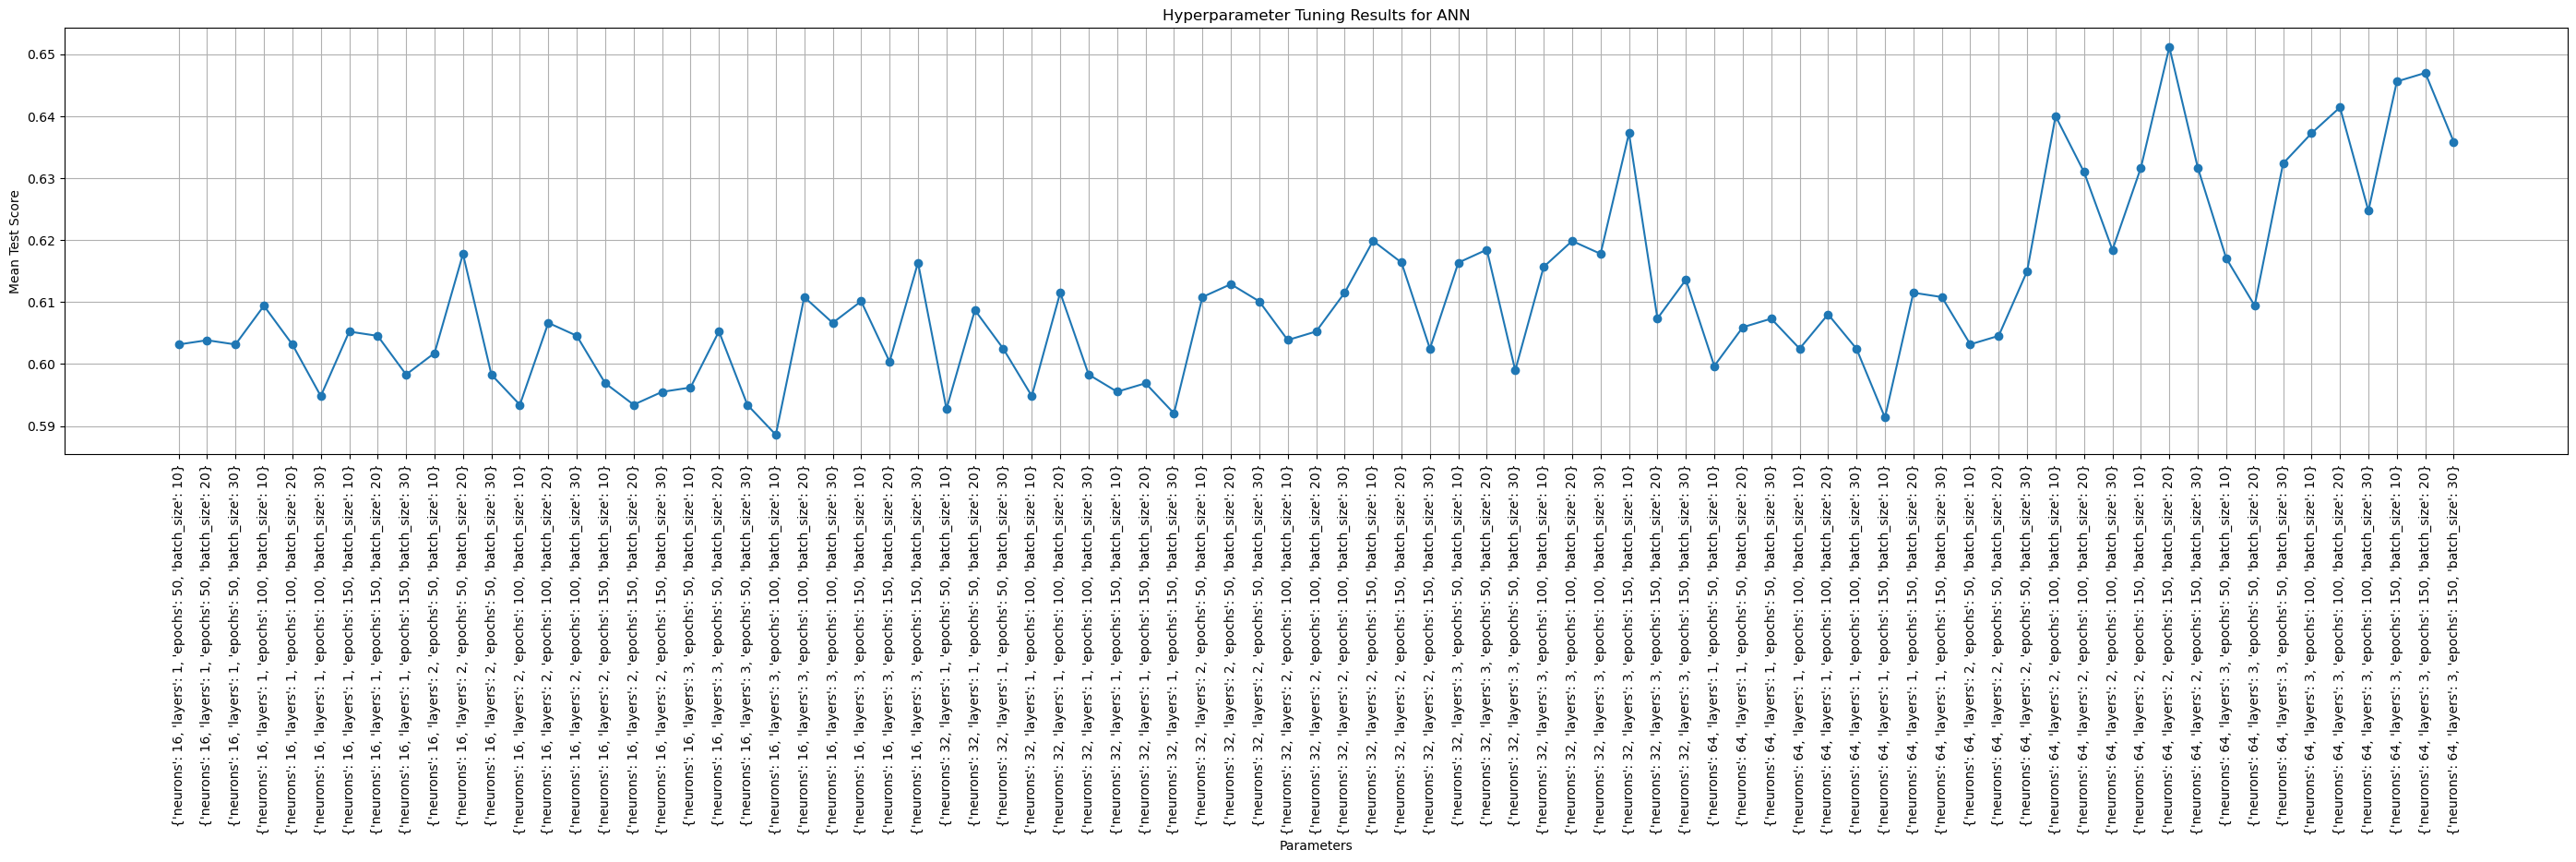

45/45 [==============================] - 0s 4ms/step - loss: 0.2102 - accuracy: 0.9437
Training completed in 0.3834 seconds.
45/45 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [6]:
full_process('processed_wine_quality.csv', 'ANN','origin')

In [22]:
X, y, X_train, X_test, y_train, y_test, num_classes = preprocess_data('processed_wine_quality.csv', 'ANN')
test_accuracy = test_model(X_train, y_train, X_test, y_test, 'ANN','origin')
print(f"Final test accuracy: {test_accuracy:.4f}")

Training completed in 0.6532 seconds.
Training Accuracy: 0.9423
Test Accuracy: 0.6375
Final test accuracy: 0.6375


Best parameters found: {'neurons': 64, 'layers': 3, 'epochs': 150, 'batch_size': 10}


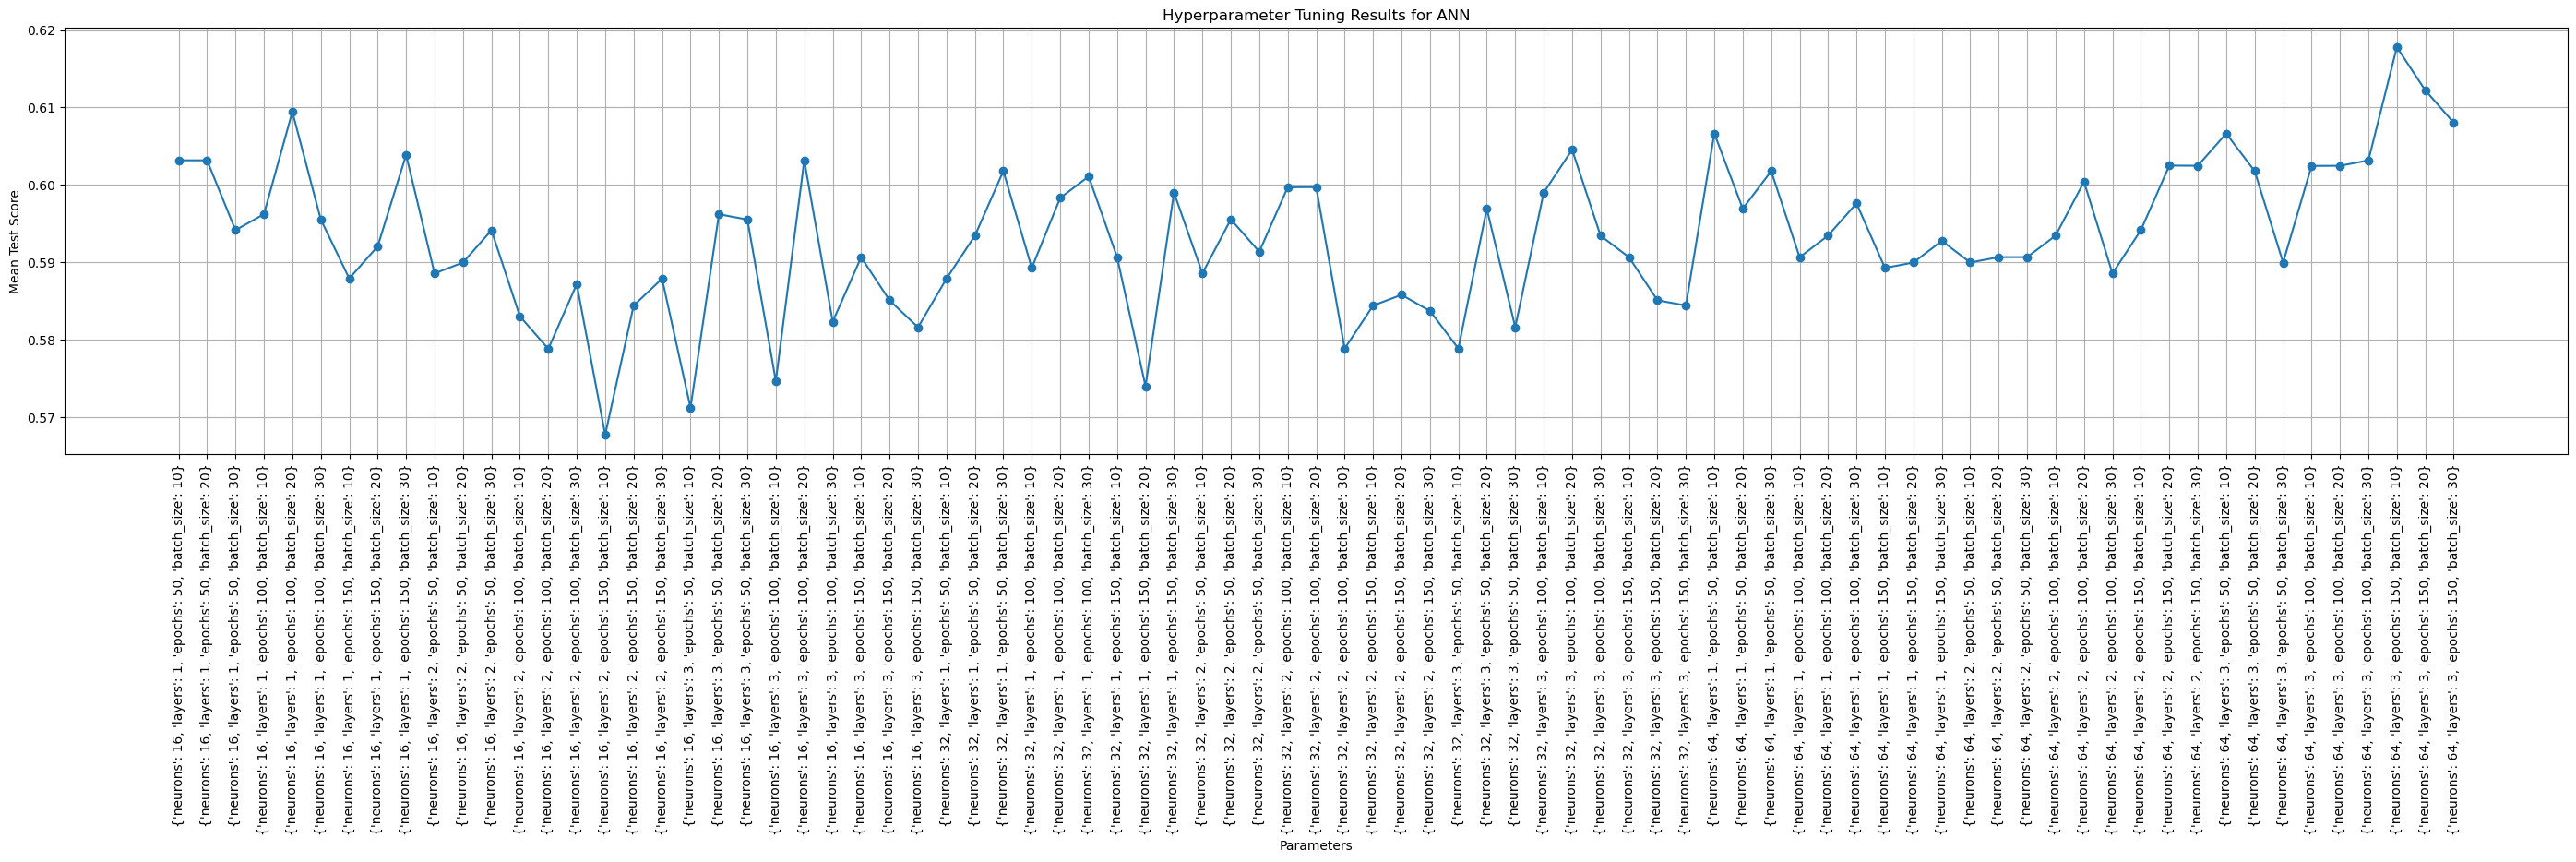

45/45 [==============================] - 0s 4ms/step - loss: 0.1024 - accuracy: 0.9757
Training completed in 0.3316 seconds.
45/45 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [7]:
full_process('processed_wine_quality_pca.csv', 'ANN','pca')

In [18]:
X, y, X_train, X_test, y_train, y_test, num_classes = preprocess_data('processed_wine_quality_pca.csv', 'ANN')
test_accuracy = test_model(X_train, y_train, X_test, y_test, 'ANN','pca')
print(f"Final test accuracy: {test_accuracy:.4f}")

Training completed in 0.3032 seconds.
Training Accuracy: 0.9764
Test Accuracy: 0.6125
Final test accuracy: 0.6125


Best parameters found: {'neurons': 32, 'layers': 3, 'epochs': 150, 'batch_size': 10}


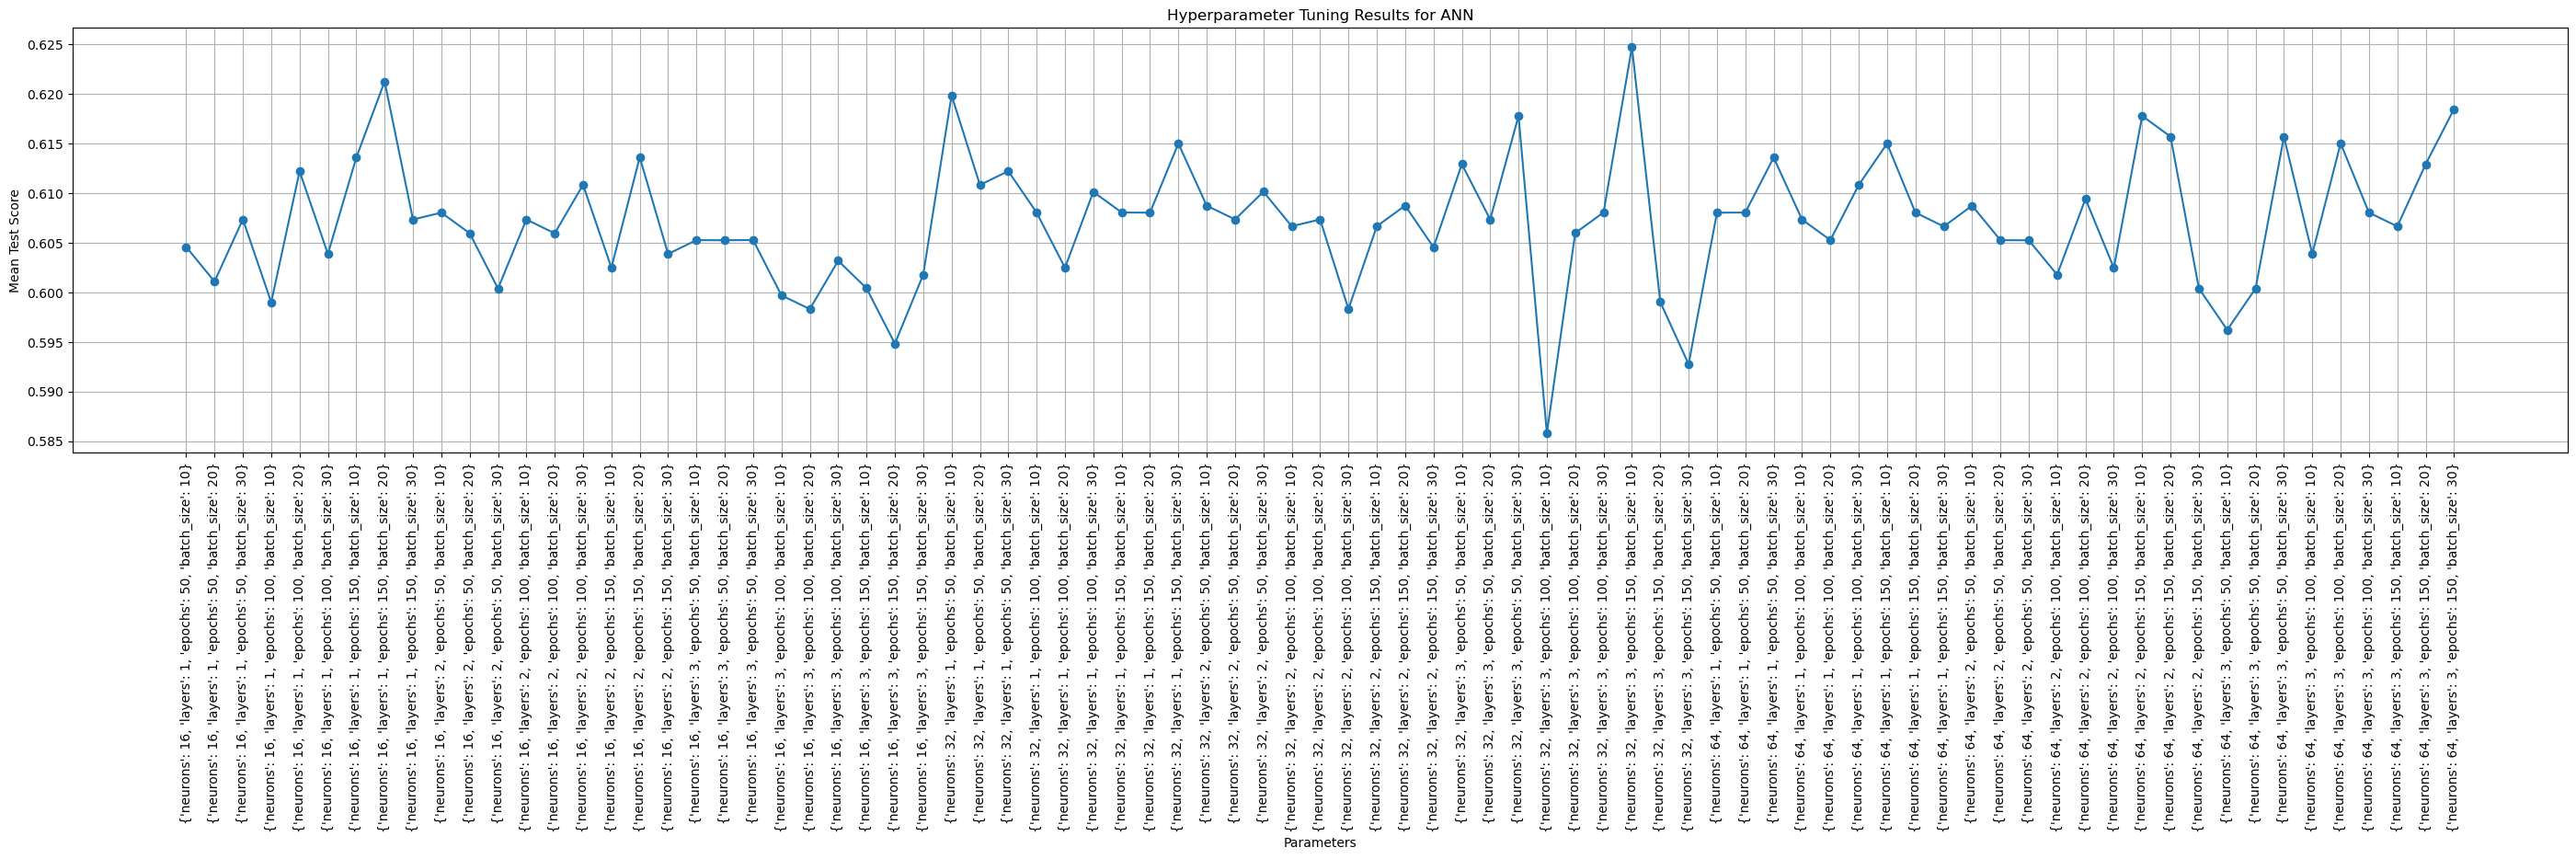

45/45 [==============================] - 0s 3ms/step - loss: 0.4697 - accuracy: 0.8075
Training completed in 0.3216 seconds.
45/45 [==============================] - 0s 1ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [8]:
full_process('processed_wine_quality_feature_selected.csv', 'ANN','feature_selected')

In [21]:
X, y, X_train, X_test, y_train, y_test, num_classes = preprocess_data('processed_wine_quality_feature_selected.csv', 'ANN')
test_accuracy = test_model(X_train, y_train, X_test, y_test, 'ANN','feature_selected')
print(f"Final test accuracy: {test_accuracy:.4f}")

Training completed in 0.3068 seconds.
Training Accuracy: 0.8374
Test Accuracy: 0.5687
Final test accuracy: 0.5687
